# Data Filtering Techniques for Synthetic Data

This notebook explores techniques for filtering and processing synthetic data generated by large language models. Based on the Cosmopedia project, we'll cover:

1. Post-Generation Cleanup
2. Deduplication Pipeline
3. Decontamination Process
4. Educational Value Classification
5. Quality Evaluation


## Setup

First, let's install the required dependencies.


In [20]:
# Basic packages
!uv pip install datasets transformers numpy scikit-learn tf-keras evaluate

# For deduplication
!uv pip install "datatrove[all]"

Using Python 3.12.8 environment at: /Users/ob1/Desktop/NVIDIA teaching kits/aisg_github_course/.venv
Audited 4 packages in 12ms
Using Python 3.12.8 environment at: /Users/ob1/Desktop/NVIDIA teaching kits/aisg_github_course/.venv
Audited 1 package in 46ms


## 1. Post-Generation Cleanup

After generating synthetic data with an LLM, we often need to clean up boilerplate text such as introductions, greetings, and template artifacts that instruction-tuned models are trained to generate as chatbots. We can start with regular expressions to identify and remove these patterns, but more complex postprocessing can be applied when you have a better understanding of the data you are generating. This will differ based on the model you are using, and in general, you should iteratively edit this post-generation cleanup process based on new observations.


In [6]:
import re
from datasets import load_dataset

# Define patterns to remove common boilerplate text
patterns = [
    # Greeting patterns
    r"^Hello.*?[.!]\s+",
    r"^My name is.*?[.!]\s+",
    r"^You've just arrived.*?[.!]\s+",
    
    # Documentation patterns
    r"^\*\*Welcome, .*?[.!]\*\*\s+",
    r"^(\*\*)?Warning:.*?[.!]\s+",
    r"^We're thrilled.*?[.!]\s+",
    
    # General introductions
    r"^Welcome, .*?[.!]\s+",
]

# Compile the patterns
compiled_patterns = [re.compile(p, flags=re.IGNORECASE|re.MULTILINE) for p in patterns]

# Function to clean text
def clean_text(sample):
    # Keep the original text
    sample['completion_unfiltered'] = sample['text']
    
    # Apply each pattern to remove boilerplate
    for pattern in compiled_patterns:
        sample['text'] = pattern.sub('', sample['text'].strip())
    
    return sample

### Example of Cleanup Results


In [22]:
# Example text with boilerplate
example_text = """Hello there! I'm excited to share this information with you.

In this article, we'll explore the fascinating world of synthetic data processing.
Let's begin by understanding what synthetic data is and why it matters.
"""

# Manual application of cleanup
sample = {'text': example_text}
cleaned = clean_text(sample)

print("Original text:\n", sample['completion_unfiltered'])
print("\nCleaned text:\n", sample['text']) # as you can tell, the clean up process is not perfect, but it is a good start. You can likely also remove "I'm excited to share this information with you".

Original text:
 Hello there! I'm excited to share this information with you.

In this article, we'll explore the fascinating world of synthetic data processing.
Let's begin by understanding what synthetic data is and why it matters.


Cleaned text:
 I'm excited to share this information with you.

In this article, we'll explore the fascinating world of synthetic data processing.
Let's begin by understanding what synthetic data is and why it matters.


In [23]:
dataset_name = "HuggingFaceTB/cosmopedia" # or replace with your dataset you uploaded from the previous notebook after generating data
data = load_dataset(dataset_name, "khanacademy")
cleaned_data = data.map(clean_text, num_proc=4)  # num_proc uses multiprocessing for larger datasets

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

## 2. Deduplication Pipeline

Deduplication is critical for removing redundant content from the dataset. We'll use the MinHash algorithm via the datatrove library, which efficiently identifies similar documents in large datasets.


In [7]:
from datatrove.pipeline.dedup import MinhashDedupSignature
from datatrove.pipeline.dedup.minhash import (
    MinhashConfig,
    MinhashDedupBuckets,
    MinhashDedupCluster,
    MinhashDedupFilter,
)
from datatrove.pipeline.readers import HuggingFaceDatasetReader
from datatrove.pipeline.tokens import TokensCounter
from datatrove.pipeline.writers.jsonl import JsonlWriter

The deduplication process consists of four stages:

1. **Compute signatures**: Generate MinHash signatures for each document
2. **Find matches**: Use LSH (Locality-Sensitive Hashing) to find potential matches
3. **Create clusters**: Group similar documents into clusters
4. **Filter duplicates**: Keep only one document per cluster

Below is an example of how to set up this pipeline using datatrove:


In [25]:
import os
from datatrove.executor.local import LocalPipelineExecutor
from datatrove.utils.hashing import HashConfig

# Configuration for MinHash deduplication
minhash_config = MinhashConfig(  hash_config=HashConfig(precision=64),
    num_buckets=14,
    hashes_per_bucket=8,)  # Default configuration

# Define the output paths (adjust as needed)
output_base_path = "./dedup_output"
os.makedirs(output_base_path, exist_ok=True)
 
reader = HuggingFaceDatasetReader( # Define the reader for input data, here we are loading from HF so HuggingFaceDatasetReader reader is used. Refer to the datatrove documentation for more details on other readers. Refer to this example pipeline used for FineWeb: https://github.com/huggingface/datatrove/blob/main/examples/fineweb.py
    dataset=dataset_name,
    dataset_options={"split": "train", "name": "khanacademy"}, # https://github.com/huggingface/datatrove/blob/main/tests/pipeline/test_hf_reader.py#L12
    text_key="text"
)

### Stage 1: Compute MinHash Signatures


In [26]:
# Stage 1: Generate signatures
stage1 = LocalPipelineExecutor(
    pipeline=[
        reader,
        MinhashDedupSignature(output_folder=f"{output_base_path}/signatures", config=minhash_config),
    ],
    tasks=1,  # Increase for larger datasets
)
stage1.run()

2025-05-14 09:09:16.873 | INFO     | datatrove.utils.logging:add_task_logger:58 - Launching pipeline for rank=0
2025-05-14 09:09:16.874 | INFO     | datatrove.utils.logging:log_pipeline:90 - 
--- 🛠️ PIPELINE 🛠
📖 - READER: 🤗 HuggingFace
🫂 - DEDUP: 🎯 MinHash stage 1


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

2025-05-14 09:11:27.163 | INFO     | datatrove.pipeline.dedup.minhash:run:262 - Sorting buckets...
2025-05-14 09:11:27.531 | SUCCESS  | datatrove.executor.base:_run_for_rank:98 - Processing done for rank=0
2025-05-14 09:11:27.533 | INFO     | datatrove.executor.base:_run_for_rank:104 - 

📉📉📉 Stats: Task 0 📉📉📉

Total Runtime: 2 minutes and 10 seconds

📖 - READER: 🤗 HuggingFace
    Runtime: (0.04%) 0 seconds [2.32 milliseconds±0.61 milliseconds/batch]
    Stats: {doc_len: 88405138 [min=5, max=18344, 3664.77±1455/doc], documents: 24123}
🫂 - DEDUP: 🎯 MinHash stage 1
    Runtime: (99.96%) 2 minutes and 10 seconds [2 minutes, 10 seconds and 656.96 milliseconds±0 milliseconds/doc]
    Stats: {total: 24123}
2025-05-14 09:11:27.537 | SUCCESS  | datatrove.executor.local:run:148 - 

📉📉📉 Stats: All 1 tasks 📉📉📉

Total Runtime: 2 minutes and 10 seconds

📖 - READER: 🤗 HuggingFace
    Runtime: (0.04%) 0 seconds [2.32 milliseconds±0.61 milliseconds/batch]
    Stats: {doc_len: 88405138 [min=5, max=18344



📉📉📉 Stats 📉📉📉

Total Runtime: 2 minutes and 10 seconds

📖 - READER: 🤗 HuggingFace
    Runtime: (0.04%) 0 seconds [2.32 milliseconds±0.61 milliseconds/batch]
    Stats: {doc_len: 88405138 [min=5, max=18344, 3664.77±1455/doc], documents: 24123}
🫂 - DEDUP: 🎯 MinHash stage 1
    Runtime: (99.96%) 2 minutes and 10 seconds [2 minutes, 10 seconds and 656.96 milliseconds±0 milliseconds/doc]
    Stats: {total: 24123}

### Stage 2: Find Matches Between Signatures


In [27]:
# Stage 2: Find matches
!export OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES # requierd for multiprocessing used in datatrove

stage2 = LocalPipelineExecutor(
    pipeline=[
        MinhashDedupBuckets(
            input_folder=f"{output_base_path}/signatures",
            output_folder=f"{output_base_path}/buckets",
            config=minhash_config,
        ),
    ],
    depends=stage1,
    tasks=minhash_config.num_buckets,
)
stage2.run()

2025-05-14 09:11:29.537 | INFO     | datatrove.utils.logging:add_task_logger:58 - Launching pipeline for rank=0
2025-05-14 09:11:29.539 | INFO     | datatrove.utils.logging:log_pipeline:90 - 
--- 🛠️ PIPELINE 🛠
🫂 - DEDUP: 🎯 MinHash stage 2
2025-05-14 09:11:29.541 | INFO     | datatrove.pipeline.dedup.minhash:run:359 - Running worker 1/1 on bucket 000. Hash range: [0, np.uint64(2305843009213693951)]
2025-05-14 09:11:29.542 | INFO     | datatrove.pipeline.dedup.minhash:run:406 - Finished initializing signatures priority queue.
2025-05-14 09:11:29.568 | SUCCESS  | datatrove.executor.base:_run_for_rank:98 - Processing done for rank=0
2025-05-14 09:11:29.578 | INFO     | datatrove.executor.base:_run_for_rank:104 - 

📉📉📉 Stats: Task 0 📉📉📉

Total Runtime: 0 seconds

🫂 - DEDUP: 🎯 MinHash stage 2
    Runtime: (100.00%) 0 seconds [27.40 milliseconds±0 milliseconds/doc]
    Stats: {total_matches: 53}
2025-05-14 09:11:29.584 | INFO     | datatrove.executor.local:_launch_run_for_rank:81 - 1/14 tasks



📉📉📉 Stats 📉📉📉

Total Runtime: 0 seconds ± 0 seconds/task

🫂 - DEDUP: 🎯 MinHash stage 2
    Runtime: (100.00%) 0 seconds±0 seconds/task, min=0 seconds, max=0 seconds [24.64 milliseconds±1.41 milliseconds/doc]
    Stats: {total_matches: 726}

### Stage 3: Create Clusters of Duplicates


In [28]:
# Stage 3: Create clusters
stage3 = LocalPipelineExecutor(
    pipeline=[
        MinhashDedupCluster(
            input_folder=f"{output_base_path}/buckets",
            output_folder=f"{output_base_path}/remove_ids",
            config=minhash_config,
        ),
    ],
    depends=stage2,
    tasks=1,
)
stage3.run()

2025-05-14 09:11:30.839 | INFO     | datatrove.utils.logging:add_task_logger:58 - Launching pipeline for rank=0
2025-05-14 09:11:30.840 | INFO     | datatrove.utils.logging:log_pipeline:90 - 
--- 🛠️ PIPELINE 🛠
🫂 - DEDUP: 🎯 MinHash stage 3
2025-05-14 09:11:30.842 | INFO     | datatrove.pipeline.dedup.minhash:run:511 - Loading dup files...
Reading dup files: 100%|██████████| 14/14 [00:00<00:00, 5647.26it/s]
2025-05-14 09:11:30.846 | INFO     | datatrove.pipeline.dedup.minhash:run:521 - Finished reading dup files.
2025-05-14 09:11:30.847 | SUCCESS  | datatrove.executor.base:_run_for_rank:98 - Processing done for rank=0
2025-05-14 09:11:30.848 | INFO     | datatrove.executor.base:_run_for_rank:104 - 

📉📉📉 Stats: Task 0 📉📉📉

Total Runtime: 0 seconds

🫂 - DEDUP: 🎯 MinHash stage 3
    Runtime: (100.00%) 0 seconds [5.31 milliseconds±0 milliseconds/doc]
    Stats: {duplicates: 69, cluster_size: 69 [min=2, max=18, 5.75±5/cluster], to_remove: 57}
2025-05-14 09:11:30.852 | SUCCESS  | datatrove.exe



📉📉📉 Stats 📉📉📉

Total Runtime: 0 seconds

🫂 - DEDUP: 🎯 MinHash stage 3
    Runtime: (100.00%) 0 seconds [5.31 milliseconds±0 milliseconds/doc]
    Stats: {duplicates: 69, cluster_size: 69 [min=2, max=18, 5.75±5/cluster], to_remove: 57}

### Stage 4: Filter Duplicates


In [29]:
# Stage 4: Filter duplicates
# Uncomment to run with a real dataset
#
stage4 = LocalPipelineExecutor(
    pipeline=[
        reader,
        TokensCounter(),  # Count tokens before and after deduplication
        MinhashDedupFilter(
            input_folder=f"{output_base_path}/remove_ids",
            exclusion_writer=JsonlWriter(f"{output_base_path}/removed"),
        ),
        JsonlWriter(output_folder=f"{output_base_path}/deduplicated_output"),
    ],
    depends=stage3,
    tasks=1,  # Match the number of tasks from stage 1
)
stage4.run()

2025-05-14 09:11:30.920 | INFO     | datatrove.utils.logging:add_task_logger:58 - Launching pipeline for rank=0
2025-05-14 09:11:30.921 | INFO     | datatrove.utils.logging:log_pipeline:90 - 
--- 🛠️ PIPELINE 🛠
📖 - READER: 🤗 HuggingFace
🔢 - TOKENIZER: 📊 Counter
🫂 - DEDUP: 🎯 MinHash stage 4
💽 - WRITER: 🐿 Jsonl


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

2025-05-14 09:12:05.418 | SUCCESS  | datatrove.executor.base:_run_for_rank:98 - Processing done for rank=0
2025-05-14 09:12:05.420 | INFO     | datatrove.executor.base:_run_for_rank:104 - 

📉📉📉 Stats: Task 0 📉📉📉

Total Runtime: 30 seconds

📖 - READER: 🤗 HuggingFace
    Runtime: (0.20%) 0 seconds [2.47 milliseconds±0.59 milliseconds/batch]
    Stats: {doc_len: 88405138 [min=5, max=18344, 3664.77±1455/doc], documents: 24123}
🔢 - TOKENIZER: 📊 Counter
    Runtime: (88.77%) 27 seconds [9 seconds and 89.86 milliseconds±3 seconds and 101.20 milliseconds/batch]
    Stats: {tokens: 20953163 [min=2, max=4439, 868.60±388/doc]}
🫂 - DEDUP: 🎯 MinHash stage 4
    Runtime: (0.10%) 0 seconds [0.00 milliseconds±0.01 milliseconds/doc]
    Stats: {total: 24123, forwarded: 24066, dropped: 57}
💽 - WRITER: 🐿 Jsonl
    Runtime: (10.93%) 3 seconds [0.14 milliseconds±0.28 milliseconds/doc]
    Stats: {XXXXX.jsonl.gz: 24066, total: 24066, doc_len: 88402371 [min=5, max=18344, 3673.33±1446/doc], doc_len_tokens: 20



📉📉📉 Stats 📉📉📉

Total Runtime: 30 seconds

📖 - READER: 🤗 HuggingFace
    Runtime: (0.20%) 0 seconds [2.47 milliseconds±0.59 milliseconds/batch]
    Stats: {doc_len: 88405138 [min=5, max=18344, 3664.77±1455/doc], documents: 24123}
🔢 - TOKENIZER: 📊 Counter
    Runtime: (88.77%) 27 seconds [9 seconds and 89.86 milliseconds±3 seconds and 101.20 milliseconds/batch]
    Stats: {tokens: 20953163 [min=2, max=4439, 868.60±388/doc]}
🫂 - DEDUP: 🎯 MinHash stage 4
    Runtime: (0.10%) 0 seconds [0.00 milliseconds±0.01 milliseconds/doc]
    Stats: {total: 24123, forwarded: 24066, dropped: 57}
💽 - WRITER: 🐿 Jsonl
    Runtime: (10.93%) 3 seconds [0.14 milliseconds±0.28 milliseconds/doc]
    Stats: {XXXXX.jsonl.gz: 24066, total: 24066, doc_len: 88402371 [min=5, max=18344, 3673.33±1446/doc], doc_len_tokens: 20952551 [min=2, max=4439, 870.63±386/doc]}

In [4]:
import json
import gzip
from pathlib import Path

output_base_path = "dedup_output"
# Load deduplicated samples created from pipeline above
dedup_path = Path(f"{output_base_path}/deduplicated_output")
dedup_files = list(dedup_path.glob("*.jsonl.gz"))
dedup_samples = []
for file in dedup_files:
    with gzip.open(file, 'rt') as f:
        for line in f:
            dedup_samples.append(json.loads(line))

# Load removed samples
removed_path = Path(f"{output_base_path}/removed")
removed_files = list(removed_path.glob("*.jsonl.gz"))
removed_samples = []
for file in removed_files:
    with gzip.open(file, 'rt') as f:
        for line in f:
            removed_samples.append(json.loads(line))

print(f"Number of deduplicated samples: {len(dedup_samples)}")
print(f"Number of removed samples: {len(removed_samples)}")

# Compare some statistics
if dedup_samples and removed_samples:
    print("\nSample statistics:")
    print(f"Deduplicated avg length: {sum(len(s['text']) for s in dedup_samples) / len(dedup_samples):.2f}")
    print(f"Removed avg length: {sum(len(s['text']) for s in removed_samples) / len(removed_samples):.2f}")
    
    # Show a few examples of removed samples
    print("\nExample removed samples:")
    for i, sample in enumerate(removed_samples[:10]):
        print(f"\nRemoved sample {i+1}:")
        print(sample['text'][:200] + "...")


Number of deduplicated samples: 24066
Number of removed samples: 57

Sample statistics:
Deduplicated avg length: 3673.33
Removed avg length: 48.54

Example removed samples:

Removed sample 1:
 Let's dive into our next lesson: adding 8 + ...

Removed sample 2:
 Now that we've learned how to multiply 1-digit numbers by 10, 100, and 1...

Removed sample 3:
 **Topic C: Lessons 26-2...

Removed sample 4:
 Dividing Whole Numbers by 1...

Removed sample 5:
 Welcome to Unit 11: Operations and Algebra < 1...

Removed sample 6:
 Welcome to Unit 17: Operations and Algebra 218-2...

Removed sample 7:
 Welcome to Unit 17: Operations and Algebra 218-2...

Removed sample 8:
 Welcome to Unit 18: Operations and Algebra 222-2...

Removed sample 9:
 When working with powers of 1...

Removed sample 10:
 Welcome to Unit 20: Operations and Algebra ...


## 3. Decontamination Process

Decontamination prevents data leakage by removing content that overlaps with evaluation benchmarks. This is especially important for synthetically generated data to ensure fair evaluation.


In [8]:
import difflib
import re
import unicodedata
from tqdm.auto import tqdm
from datasets import Dataset

### Text Normalization and N-gram Generation


In [1]:
def tokenize(text): # find out what and how this function does!
    """Normalize text by removing diacritics and tokenize."""
    text = "".join(c for c in unicodedata.normalize("NFD", text) if unicodedata.category(c) != "Mn")
    tokens = re.findall("\\w+", text.lower())
    return tokens

def get_ngrams(tokens, n): # analyze what this function does!
    """Generate n-grams from tokens."""
    return set(zip(*[tokens[i:] for i in range(n)]))

### Finding N-gram Matches with Benchmarks


In [2]:
def retrieve_ngrams_batch(batch, eval_ngrams, eval_datasets, eval_texts, ngram_len):
    """Find contaminated samples based on n-grams."""
    new_batch = {"completion": [], "ngram": [], "bench_name": [], "bench_text": []}
    for completion in batch["text"]:
        tokens = tokenize(completion)
        ngrams = get_ngrams(tokens, ngram_len)
        for ngram in ngrams:
            if ngram in eval_ngrams:
                idx = eval_ngrams[ngram]
                new_batch["completion"].append(completion)
                new_batch["ngram"].append(ngram)
                new_batch["bench_name"].append(eval_datasets[idx])
                new_batch["bench_text"].append(eval_texts[idx])
                break
    return new_batch

### Sequence Matching for Better Precision


In [3]:
def diff_strings(string1, string2):
    """Find matching parts between two strings."""
    matcher = difflib.SequenceMatcher(None, string1.lower(), string2.lower(), autojunk=False)
    matching_blocks = matcher.get_matching_blocks()
    matches = []
    for block in matching_blocks:
        start_a, start_b, length = block
        if length > 5:  # Ignore very short matches
            match = string1[start_a:start_a + length]
            matches.append(match)
    return matches

def add_match_stats(example):
    """Add match statistics to identify contamination severity."""
    gen_text = " ".join(tokenize(example["completion"]))
    bench_text = " ".join(tokenize(example["bench_text"]))
    matching_parts = diff_strings(gen_text, bench_text)
    match = " ".join("".join(matching_parts).split())
    example["diff"] = matching_parts
    example["diff_ratio"] = len(match) / len(bench_text) if len(bench_text) > 0 else 0
    example["diff_length"] = len(match)
    example["longest_diff_part"] = max(matching_parts, key=len, default="")
    example["longest_diff_part_length"] = len(example["longest_diff_part"])
    return example

### Complete Decontamination Pipeline

The function below demonstrates the complete decontamination process.


In [14]:
def decontaminate_dataset(train_dataset, eval_dataset, ngram_length=10, diff_threshold=0.5, num_proc=4):
    """
    Decontaminate a dataset by removing examples that have significant overlap with evaluation benchmarks.
    
    Args:
        train_dataset: Dataset to decontaminate
        eval_dataset: Evaluation benchmark dataset
        ngram_length: Length of n-grams to use for initial matching
        diff_threshold: Similarity threshold for filtering (0.5 = 50% match)
        num_proc: Number of processes for parallel processing
        
    Returns:
        Tuple of (decontaminated dataset, contamination report)
    """
    # Build n-gram index from evaluation data
    eval_ngrams, eval_datasets, eval_texts = {}, [], []
    
    print("Building n-gram index from evaluation data...")
    for example in tqdm(eval_dataset):
        tokens = tokenize(example["text"])
        ngrams = get_ngrams(tokens, ngram_length)
        if ngrams:
            idx = len(eval_texts)
            eval_ngrams.update(zip(ngrams, [idx] * len(ngrams)))
            eval_datasets.append(example.get("task_name", "unknown"))
            eval_texts.append(example["text"])
            
    print(f"Created n-gram index with {len(eval_ngrams)} unique n-grams")
    
    # Find contamination candidates
    print("Finding contamination candidates...")
    contamination_report = train_dataset.map(
        lambda batch: retrieve_ngrams_batch(batch, eval_ngrams, eval_datasets, eval_texts, ngram_length),
        batched=True, batch_size=1000, num_proc=num_proc, remove_columns=train_dataset.column_names
    )
    
    # Add detailed matching statistics
    print("Analyzing match details...")
    contamination_report = contamination_report.map(
        lambda example: add_match_stats(example), num_proc=num_proc
    )
    
    # Filter based on similarity threshold
    print("Filtering contaminated examples...")
    contamination_report_filtered = contamination_report.filter(lambda x: x["diff_ratio"] > diff_threshold)
    
    # Create decontaminated dataset
    contaminated_completions = set(contamination_report_filtered["completion"])
    filtered_data = train_dataset.filter(lambda x: x["text"] not in contaminated_completions)
    
    print(f"Found {len(contamination_report_filtered)} contaminated examples out of {len(train_dataset)}")
    print(f"Decontaminated dataset has {len(filtered_data)} examples")
    
    return filtered_data, contamination_report

In [ ]:
# Example usage (uncomment to run with real datasets)
# train_dataset_name = "HuggingFaceTB/cosmopedia-sample" # or replace with 
train_dataset_name = "dedup_output/deduplicated_output"
# eval_dataset_name = "VGraf/unseen_wildchat_eval_subset"
eval_dataset_name = "davanstrien/cosmopedia_sample" # has 2% of 200 samples from KhanAcademy, so should contain 4 overlapping examples
# 
train_data = load_dataset(train_dataset_name, split="train")
eval_data = load_dataset(eval_dataset_name, split="train")

decontaminated_data, contamination_report = decontaminate_dataset(
    train_data, 
    eval_data,
    ngram_length=10,
    diff_threshold=0.5,
    num_proc=4
)

Building n-gram index from evaluation data...


  0%|          | 0/200 [00:00<?, ?it/s]

Created n-gram index with 93444 unique n-grams
Finding contamination candidates...
Analyzing match details...
Filtering contaminated examples...


Filter:   0%|          | 0/24066 [00:00<?, ? examples/s]

Found 4 contaminated examples out of 24066
Decontaminated dataset has 24062 examples


## 4. Quality Scoring for educational value

Classifying educational value helps identify high-quality content for learning purposes. We will first show how we can use a trained educational classifier to filter out low-quality content. 

Since we have not yet covered how finetuning models work, we will provide sample code for how to fine-tune a BERT model to score educational value, and you can come back to this section later in the course when you have covered how to finetune models.

In [ ]:
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification,
)
import numpy as np
import evaluate

### Preparing the Dataset


In [21]:
# def prepare_educational_dataset(dataset_name, target_column="score"):
#     """Prepare a dataset for educational value classification training."""
#     # Load dataset with annotations
#     dataset = load_dataset(dataset_name, split="train")
    
#     # Normalize scores to 0-5 range
#     dataset = dataset.map(
#         lambda x: {target_column: np.clip(int(x[target_column]), 0, 5)},
#         num_proc=4,
#     )
    
#     # Convert to classification labels
#     from datasets import ClassLabel
#     dataset = dataset.cast_column(
#         target_column, ClassLabel(names=[str(i) for i in range(6)])
#     )
    
#     # Split into train and test sets
#     dataset = dataset.train_test_split(
#         train_size=0.9, seed=42, stratify_by_column=target_column
#     )
    
#     return dataset

### Evaluation Metrics


We are predicting if a text is educational or not, so the evaluation metric we will use is precision, recall, f1, and accuracy. Possible output values range from 0 to 5, and we can compare outputs to the ground truth labels.

In [22]:
# import evaluate

# def compute_metrics(eval_pred):
#     """Compute evaluation metrics for educational value classification."""
#     precision_metric = evaluate.load("precision")
#     recall_metric = evaluate.load("recall")
#     f1_metric = evaluate.load("f1")
#     accuracy_metric = evaluate.load("accuracy")

#     logits, labels = eval_pred
#     preds = np.round(logits.squeeze()).clip(0, 5).astype(int)
#     labels = np.round(labels.squeeze()).astype(int)
    
#     precision = precision_metric.compute(
#         predictions=preds, references=labels, average="macro"
#     )["precision"]
#     recall = recall_metric.compute(
#         predictions=preds, references=labels, average="macro"
#     )["recall"]
#     f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
#     accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    
#     from sklearn.metrics import classification_report, confusion_matrix
#     report = classification_report(labels, preds)
#     cm = confusion_matrix(labels, preds)
#     print("Validation Report:\n" + report)
#     print("Confusion Matrix:\n" + str(cm))

#     return {
#         "precision": precision,
#         "recall": recall,
#         "f1_macro": f1,
#         "accuracy": accuracy,
#     }

### Model Training Function


In [ ]:
# def train_educational_classifier(dataset, base_model_name, target_column="score", output_dir="./edu_bert_model"):
#     """Train a BERT model for educational value classification."""
#     # Load model and tokenizer
#     model = AutoModelForSequenceClassification.from_pretrained(
#         base_model_name,
#         num_labels=1,  # Regression task
#         classifier_dropout=0.0,
#         hidden_dropout_prob=0.0,
#         output_hidden_states=False,
#     )
#     tokenizer = AutoTokenizer.from_pretrained(
#         base_model_name,
#         model_max_length=min(model.config.max_position_embeddings, 512),
#     )
#     if not tokenizer.pad_token:
#         tokenizer.pad_token = tokenizer.eos_token
    
#     # Preprocess data
#     def preprocess(examples):
#         batch = tokenizer(examples["text"], truncation=True)
#         batch["labels"] = np.float32(examples[target_column])
#         return batch
    
#     processed_dataset = dataset.map(preprocess, batched=True)
#     data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
#     # Freeze embedding layers to speed up training
#     for param in model.bert.embeddings.parameters():
#         param.requires_grad = False
#     for param in model.bert.encoder.parameters():
#         param.requires_grad = False
    
#     # Training arguments
#     training_args = TrainingArguments(
#         output_dir=output_dir,
#         eval_strategy="steps",
#         save_strategy="steps",
#         eval_steps=1000,
#         save_steps=1000,
#         logging_steps=100,
#         learning_rate=3e-4,
#         num_train_epochs=5,
#         seed=0,
#         per_device_train_batch_size=32,
#         per_device_eval_batch_size=64,
#         eval_on_start=True,
#         load_best_model_at_end=True,
#         metric_for_best_model="f1_macro",
#         greater_is_better=True,
#     )
    
#     # Initialize trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=processed_dataset["train"],
#         eval_dataset=processed_dataset["test"],
#         tokenizer=tokenizer,
#         data_collator=data_collator,
#         compute_metrics=compute_metrics,
#     )
    
#     # Train model
#     trainer.train()
#     trainer.save_model(output_dir)
    
#     return model, tokenizer

In [ ]:
# Example usage (uncomment to run with real data)
# 
# dataset_name = "HuggingFaceFW/fineweb-edu-llama3-annotations"  
# base_model_name = "Snowflake/snowflake-arctic-embed-m"

# # Prepare dataset
# edu_dataset = prepare_educational_dataset(dataset_name, target_column="score")
# 
# # Train model
# model, tokenizer = train_educational_classifier(
#     edu_dataset, 
#     base_model_name, 
#     target_column="score",
#     output_dir="./edu_bert_model"
# )

### Using the Model for Classification


In [26]:
import torch

def classify_educational_value(dataset, model_path, batch_size=32):
    """Apply educational value classification to a dataset."""
    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # Define preprocessing function
    def predict_batch(batch):
        # Tokenize and prepare inputs
        inputs = tokenizer(batch["text"], truncation=True, padding=True, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Process predictions
        scores = outputs.logits.squeeze().cpu().numpy()
        scores = np.clip(np.round(scores), 0, 5).astype(int)
        
        batch["educational_score"] = scores
        return batch
    
    # Apply model to dataset
    scored_dataset = dataset.map(
        predict_batch,
        batched=True,
        batch_size=batch_size
    )
    
    return scored_dataset

In [27]:
 
dataset_to_score = load_dataset("davanstrien/cosmopedia_sample", split="train")
model_path = "HuggingFaceFW/fineweb-edu-classifier"  # or use your locally trained edu BERT model "./edu_bert_model"

scored_dataset = classify_educational_value(dataset_to_score, model_path)

# Example of filtering by educational value
high_quality = scored_dataset.filter(lambda x: x["educational_score"] >= 4)
print(f"Original dataset: {len(scored_dataset)} examples")
print(f"High-quality subset: {len(high_quality)} examples")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Original dataset: 200 examples
High-quality subset: 114 examples


In [28]:
# Print 5 high quality examples
print("\nHigh Quality Examples (score >= 4):")
for i, example in enumerate(high_quality.select(range(5))):
    print(f"\nExample {i+1}:")
    print(f"Score: {example['educational_score']}")
    print(f"Text: {example['text'][:200]}...")  # Print first 200 chars

# Print 5 low quality examples
low_quality = scored_dataset.filter(lambda x: x["educational_score"] < 4)
print("\nLow Quality Examples (score < 4):")
for i, example in enumerate(low_quality.select(range(5))):
    print(f"\nExample {i+1}:")
    print(f"Score: {example['educational_score']}")
    print(f"Text: {example['text'][:200]}...")  # Print first 200 chars



High Quality Examples (score >= 4):

Example 1:
Score: 4
Text:  The terms "infimum" and "supremum" are fundamental concepts in mathematics, particularly within the branch of order theory. They are often used when discussing partially ordered sets, which refer to ...

Example 2:
Score: 5
Text:  Hello young mathematicians! Today, let's learn about circles and some interesting properties they have.

First, do you know what a circle is? A circle is a shape where all points are equidistant (the...

Example 3:
Score: 4
Text:  Absolute value inequalities can indeed be tricky, especially when they involve more than one absolute value expression. The key to solving these types of problems lies in considering all possible cas...

Example 4:
Score: 5
Text:  The fundamental principle of counting is a crucial concept in combinatorics, a branch of mathematics concerned with counting, arrangement, and selection of elements from finite sets. This principle, ...

Example 5:
Score: 4
Text:  Sure, I'll 

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]


Low Quality Examples (score < 4):

Example 1:
Score: 3
Text:  Category theory is a branch of mathematics that deals with abstract structure and relationships between mathematical concepts. At its core, it studies how various mathematical structures can be viewe...

Example 2:
Score: 2
Text:  Introduction

In contemporary sociological discourse, the economy is increasingly viewed as a complex system embedded within broader social structures (Polanyi, 1944; Granovetter, 1985). This perspec...

Example 3:
Score: 3
Text:  **Relating E-field and B-field Strengths in Electromagnetic Wave Propagation**

In the realm of electromagnetic wave (EM) propagation, a fundamental relationship exists between the electric ($E$) and...

Example 4:
Score: 3
Text:  Hello Grade-Schoolers! Today we're going to learn about something really cool - how to tell if a number is "divisible" by another number. This means we can figure out whether one number goes into ano...

Example 5:
Score: 3
Text:  **Unit: Midte

## 5. Quality Evaluation

Evaluating the quality of processed data is crucial to ensure its effectiveness. We can use benchmark tests to assess model performance when trained on our filtered data.


### Benchmark Testing with lighteval

The Cosmopedia project uses the `lighteval` library to evaluate models on standard benchmarks. Below is an example of how to set up and run these evaluations.


In [ ]:
# Example of installing lighteval (uncomment to run)
# 
# !git clone https://github.com/huggingface/lighteval.git
# !cd lighteval && pip install '.[accelerate,quantization,adapters]'

The primary benchmark used for evaluation is:

**HellaSwag**: A challenging common sense reasoning benchmark that tests a model's ability to complete a sentence with the most natural continuation. This is particularly effective for measuring how well a model has learned common sense knowledge and language fluency from the training data.

Using a single benchmark like HellaSwag provides an efficient way to measure the impact of different filtering steps without the complexity of multiple benchmarks.


In [ ]:
# Example command to run HellaSwag evaluation (uncomment to run)
# MODEL="your_model_checkpoint"
# OUTPUT_DIR="./eval_results"
# 
# !accelerate launch --num_processes=1 --main_process_port=29600 \
#     "lighteval/run_evals_accelerate.py" \
#     --model_args="pretrained=$MODEL" \
#     --custom_tasks "lighteval_tasks.py" \
#     --output_dir $OUTPUT_DIR \
#     --override_batch_size 16 \
#     --tasks "custom|hellaswag|0|1"

### Measuring Impact of Filtering Steps

To understand the effectiveness of different filtering approaches, you can train models on different versions of your dataset:


1. **Raw dataset**: Generated data without any filtering
2. **Cleaned dataset**: After boilerplate removal
3. **Deduplicated dataset**: After removing duplicates
4. **Decontaminated dataset**: After removing benchmark overlap
5. **High-quality dataset**: After filtering by educational value

Then evaluate each model on the benchmarks to compare performance differences.


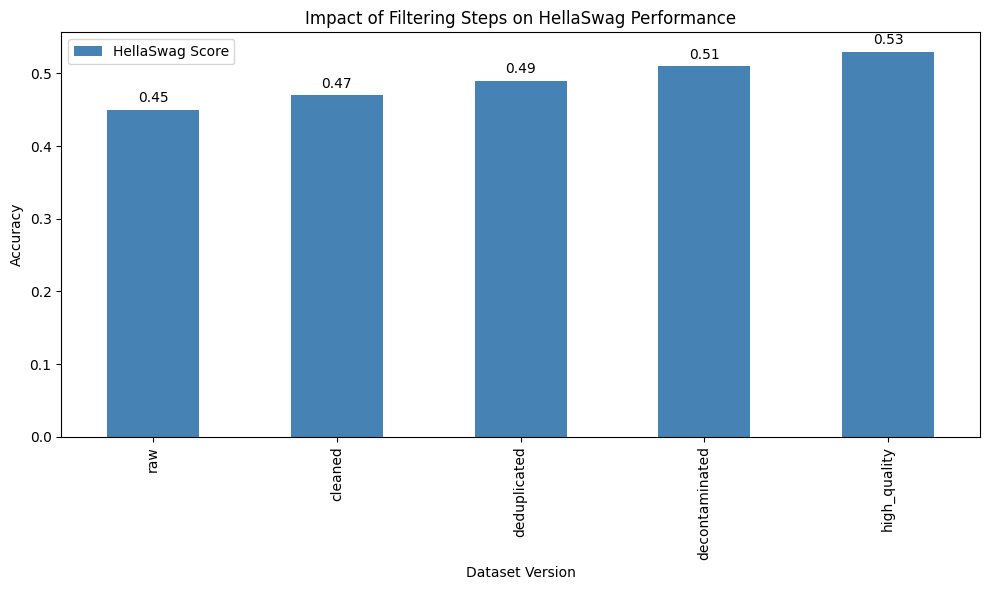

In [29]:
# Example comparative analysis for HellaSwag scores (pseudocode)

results = {
    "raw": 0.45,           # Hypothetical HellaSwag accuracy 
    "cleaned": 0.47,       # After boilerplate removal
    "deduplicated": 0.49,  # After removing duplicates
    "decontaminated": 0.51, # After removing benchmark overlap
    "high_quality": 0.53,  # After filtering by educational value
}

import matplotlib.pyplot as plt
import pandas as pd

# Plot results
df = pd.DataFrame({'HellaSwag Score': results.values()}, index=results.keys())

ax = df.plot(kind="bar", figsize=(10, 6), color='steelblue')
ax.set_title("Impact of Filtering Steps on HellaSwag Performance")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Dataset Version")

# Add value labels on bars
for i, v in enumerate(results.values()):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center')
    
plt.tight_layout()
plt.show()

## Conclusion

This notebook covers essential data filtering techniques for synthetic data:

1. **Post-Generation Cleanup**: Remove boilerplate and template artifacts with regex
2. **Deduplication**: Eliminate redundant content with MinHash and LSH
3. **Decontamination**: Prevent data leakage by removing evaluation benchmark overlap
4. **Educational Value Classification**: Score and filter content by educational quality
5. **Quality Evaluation**: Assess the impact of filtering steps on HellaSwag performance

These techniques help create high-quality datasets for training language models. By measuring performance on HellaSwag after each filtering step, we can quantify the impact of our data processing pipeline and ensure we're creating the most effective training data possible.
